In [1]:
# Set width of Jupyter cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import glob
import os
import json
import geopy.distance
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from datetime import date
from dateutil.relativedelta import relativedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import foodie_features

In [3]:
pd.set_option('display.max_row', 200)
pd.set_option('display.max_columns', 25)

In [4]:
def pull_raw_business_data():
    raw_businesses_df = pd.read_json('yelp_reviews/business.json',lines=True)
    return raw_businesses_df

In [5]:
def clean_business_data(businesses_df,
                        review_threshold=10,
                        required_num_of_closed_thresh_in_state=1000,
                        required_num_of_closed_thresh_in_city=0, 
                        city_filter_list=None,
                        type_of_business_list=None,
                        remove_hours=False):
    
    # remove states which don't have enough closed businesses
    if city_filter_list is None:
        num_of_closed_businesses_by_state_df = businesses_df.groupby('state')['is_open'].count() - businesses_df.groupby('state')['is_open'].sum()
    
        filtered_out_states = list(num_of_closed_businesses_by_state_df[num_of_closed_businesses_by_state_df > required_num_of_closed_thresh_in_state].index)
    
        print "Num of states filtered out: ", len(filter_out_states), ' Num of states left: ', len(businesses_df['state'].unique()) - len(filter_out_states)
    
        cleaned_businesses_df = businesses_df[ ~businesses_df['state'].isin(filter_out_states) ]
    else:
        cleaned_businesses_df = businesses_df
        
    # capitalize first letter in city names
    businesses_df['city'] = businesses_df['city'].apply(lambda x: x.title())
    
    # remove cities which don't have enough closed businesses
    #num_of_closed_businesses_by_city_df = businesses_df.groupby('city')['is_open'].count() - businesses_df.groupby('city')['is_open'].sum()
    
    #filtered_out_cities = list(num_of_closed_businesses_by_city_df[num_of_closed_businesses_by_city_df > required_num_of_closed_thresh_in_city].index)
    
    #cleaned_businesses_df = cleaned_businesses_df[ ~cleaned_businesses_df['city'].isin(filtered_out_cities) ]
    
    # remove business that don't have enough reviews 
    cleaned_businesses_df = cleaned_businesses_df[ cleaned_businesses_df['review_count'] >= review_threshold ]
    
    # filter only for a particular city if you so choose
    if city_filter_list is not None:
        if type(city_filter_list) is not list: 
            return "Please pass in the city filters as a list"
        else:
            cleaned_businesses_df = cleaned_businesses_df[ cleaned_businesses_df['city'].isin(city_filter_list) ]
        
    # filter only for a particular type of business if you so choose
    if type_of_business_list is not None:
        if type(type_of_business_list) is not list: 
            return "Please pass in the type of business filters as a list"
        else:
            for type_of_business in type_of_business_list:
                cleaned_businesses_df = cleaned_businesses_df[ cleaned_businesses_df['categories'].str.contains(type_of_business, na=False) ]
    
    # get all categories
    raw_categories = [category for category in cleaned_businesses_df.categories.unique() if category is not None]
    categories = np.unique([x[1:] if x[0] == ' ' else x for category in raw_categories for x in category.split(',') ])
    
    # drop useless columns
    cleaned_businesses_df.drop(['state','postal_code'],axis=1,inplace=True)
    if remove_hours is True:
        cleaned_businesses_df.drop(['hours'],axis=1, inplace=True)

    cleaned_businesses_df.set_index('business_id',inplace=True)
    
    return cleaned_businesses_df, categories

In [6]:
def find_num_of_nearby_businesses(businesses_df, n=-1, miles=10):
    
    if n == -1:
        n = businesses_df.shape[0]
        
    dist_func = lambda x,y: geopy.distance.distance(x,y).miles
    distances = pdist(businesses_df[['latitude','longitude']].values[:n], metric=dist_func)
    dist_matrix = squareform(distances)
    
    count_of_businesses_within_distance = np.sum((dist_matrix < miles),axis=1) - 1 # 1 for the diagonal element
    count_of_businesses_within_distance
    
    return count_of_businesses_within_distance # returns n x 1 array -- REMOVE n

In [7]:
def clean_reviews_data(business_ids):
    yelp_review_path = os.path.abspath(os.getcwd()) + '/yelp_reviews/'
    review_files = glob.glob1(yelp_review_path, "split_reviews*")
    reviews_df = pd.DataFrame()
    for review_file in review_files:
        review_df = pd.read_json(yelp_review_path + review_file, lines=True)
        
        reviews_df = pd.concat([reviews_df, review_df[review_df['business_id'].isin(business_ids)]], ignore_index=True)
        
        del review_df
        
    return reviews_df

def clean_users_data(review_user_ids):
    yelp_review_path = os.path.abspath(os.getcwd()) + '/yelp_reviews/'
    user_files = glob.glob1(yelp_review_path, "split_users*")
    users_df = pd.DataFrame()
    for user_file in user_files:
        user_df = pd.read_json(yelp_review_path + user_file, lines=True)
    
        users_df = pd.concat([users_df, user_df[user_df['user_id'].isin(review_user_ids)]], ignore_index=True)
        
        del user_df
        
    return users_df

In [8]:
NOV_14_2018 = date(2018, 11, 14)

def calculate_additional_features(businesses_df, reviews_df, count_of_businesses_within_distance=None):
    
    open_restaurants_yelp_api_data_df = pd.read_pickle('./open_restaurants_yelp_api_data_df.pkl').rename(columns={'price':'cost'})
    open_restaurants_yelp_api_data_df['cost'] = open_restaurants_yelp_api_data_df['cost'].map(lambda x: len(x))
    businesses_df['latitude'].update(open_restaurants_yelp_api_data_df['latitude'])
    businesses_df['longitude'].update(open_restaurants_yelp_api_data_df['longitude'])
    
    # is restaurant claimed
    businesses_df['is_claimed'] = [False for i in range(businesses_df.shape[0])]
    businesses_df['is_claimed'].update(open_restaurants_yelp_api_data_df['is_claimed'])
    businesses_df['is_claimed'] = businesses_df['is_claimed'].apply(lambda x: 1 if x is True else 0)
    
    # compute actual review counts since the dataset is wrong
    businesses_df['actual_review_count'] = reviews_df['business_id'].value_counts()
    
    # compute actual star rating based on actual reviews since the dataset might be wrong and yelp doesn't compute precise ratings
    businesses_df['actual_stars'] = reviews_df.groupby('business_id')['stars'].mean()
    
    # is restaurant a chain (find if business name is not unique)
    chains = businesses_df[businesses_df.name.duplicated(keep=False)].sort_values(by='name').name.unique()
    businesses_df['is_chain'] = businesses_df.name.isin(chains)
    businesses_df['is_chain'] = businesses_df['is_chain'].apply(lambda x: 1 if x is True else 0)
    
    # check if location has multiple closures (TODO fix the fact that the first duplicate location shouldn't matter)
    duplicate_lat_filter = businesses_df.latitude.duplicated(keep=False)
    duplicate_long_filter = businesses_df.longitude.duplicated(keep=False)
    duplicate_locations_df = businesses_df[ (duplicate_lat_filter) & (duplicate_long_filter) ].sort_values(by='latitude')[['latitude','longitude']]
    duplicate_locations = businesses_df.isin(duplicate_locations_df)
    
    businesses_df['duplicate_location'] = duplicate_locations.latitude & duplicate_locations.longitude
    businesses_df['duplicate_location'] = businesses_df['duplicate_location'].apply(lambda x: 1 if x is True else 0)
        
    # add if business has parking
    parking_attrbs = [(key, value[u'BusinessParking']) \
                      if value is not None and 'BusinessParking' in value else (key, 'False') \
                      for key,value in yelp_businesses_df.attributes.iteritems()]
    has_parking_tuples = [(attrbs[0], 'True' in attrbs[1]) for attrbs in parking_attrbs]
    business_ids, has_parking = zip(*has_parking_tuples)
    has_parking_series = pd.Series(has_parking, business_ids)

    businesses_df['has_parking'] = has_parking_series
    businesses_df['has_parking'] = businesses_df['has_parking'].apply(lambda x: 1 if x is True else 0)
    
    # add in cost of restaurant (TODO fix the fact that some restaurants had incomplete data so have 0 under price)
    price_attrbs = [(key, int(value[u'RestaurantsPriceRange2'])) \
                    if value is not None and 'RestaurantsPriceRange2' in value and value[u'RestaurantsPriceRange2'] != u'None' else (key, 1) \
                    for key, value in yelp_businesses_df.attributes.iteritems() ]
    business_ids, cost_rating = zip(*price_attrbs)
    cost = pd.Series(cost_rating, business_ids)
    
    businesses_df['cost'] = cost
    businesses_df['cost'].update(open_restaurants_yelp_api_data_df['cost'])
    
    # proxy for when restaurant open/closed, make sure to include updated dates
    bus_date_df = reviews_df[reviews_df.business_id.duplicated(keep=False)].sort_values(by=['business_id','date'])
    open_dates = bus_date_df.drop_duplicates(subset=['business_id'],keep='first').set_index('business_id')
    closed_dates = bus_date_df.drop_duplicates(subset=['business_id'],keep='last').set_index('business_id')

    open_closed_dates_df = pd.DataFrame(data={'open_dates' : open_dates.date, 'closed_dates' : closed_dates.date, 'is_open' : businesses_df.is_open}, index=open_dates.index)
    open_closed_dates_df['open_dates'] = open_closed_dates_df['open_dates'].apply(lambda x: x.date())
    open_closed_dates_df['closed_dates'] = open_closed_dates_df['closed_dates'].apply(lambda x: x.date())

    businesses_df['open_dates'] = open_closed_dates_df.open_dates
    businesses_df['closed_dates'] = open_closed_dates_df.closed_dates
    
    businesses_df.loc[businesses_df['is_open'] == 1, 'days_since_closed'] = 0
    businesses_df.loc[businesses_df['is_open'] == 1, 'closed_dates'] = NOV_14_2018 # 2018-11-14 is the last day in this dataset
    
    closed_ages = NOV_14_2018 - pd.to_datetime(closed_dates.date, format='%Y%m%d').dt.date
    open_ages = businesses_df['closed_dates'] - pd.to_datetime(open_dates.date, format='%Y%m%d').dt.date
    
    businesses_df['age (in days)'] = open_ages.dt.days
    businesses_df['days_since_closed'] = closed_ages.dt.days
    
    # relative review count, rating, price
    
    # is restaurant claimed on yelp by owner
    
    # number of restaurants within 10 miles
    #businesses_df['all_num_restaurant_within_10_miles'] = count_of_businesses_within_distance
    
    # drop attributes
    #businesses_df.drop(['attributes'],axis=1,inplace=True)

    return chains, duplicate_locations_df

In [9]:
reload(foodie_features)

<module 'foodie_features' from 'foodie_features.pyc'>

In [10]:
VEGAS_VISITORS_BY_YEAR = {'2018' : 42.12, '2017': 39.01, '2016': 42.94, '2015' : 42.31, '2014' : 41.13, '2013' : 39.67, '2012' : 39.73, '2011' : 38.93, '2010' : 37.34, '2009' : 36.35}
VEGAS_VISITORS_2018_BY_MONTH = {'1' : 3393900, '2' : 3130400, '3' : 3749800, '4'  : 3548000, '5'  : 3630400, '6'  : 3565400,\
                                '7' : 3659600, '8' : 3555200, '9' : 3457500, '10' : 3680600, '11' : 3478500, '12' : 3267600 }
VEGAS_POPULATION_BY_YEAR = {'2018' : 42.12, '2017': 39.01, '2016': 42.94, '2015' : 42.31, '2014' : 41.13, '2013' : 39.67, '2012' : 39.73, '2011' : 38.93, '2010' : 37.34, '2009' : 36.35}
def build_X_and_y(businesses_df, reviews_df, date, load_NLP=False, do_distance=False, features=None):
    """
    date: needs to be in a date object from the datetime library
    """
    before_date_filter = reviews_df.date <= pd.Timestamp(date)
    after_date_filter = reviews_df.date > pd.Timestamp(date)
    after_six_months_after_date_filter = reviews_df.date > pd.Timestamp(date + relativedelta(months=6))
        
    reviews_before_date_df = reviews_df[before_date_filter] # all reviews before date (i.e. they were open before date)
    reviews_after_date_df = reviews_df[after_date_filter] # all reviews after date (i.e. they were open after date)
    
    # restaurants with reviews both before and after date
    restaurant_ids = list( set(reviews_before_date_df.business_id.values) & set(reviews_after_date_df.business_id.values) )
    reviews_for_open_businesses = reviews_df[reviews_df.business_id.isin(restaurant_ids)]  
    reviews_for_open_businesses_before_date = reviews_for_open_businesses[before_date_filter]
    
    # find number of other restaurants with same yelp categories
    business_category_counts = foodie_features.calculate_category_counts(businesses_df)
    
    # NLP score -- grab 3 most recent reviews since that's what allowed by yelp
    sentiment, avg_review_length = foodie_features.calculate_review_sentiment_and_length(reviews_for_open_businesses_before_date, load_NLP)
    
    # compute review count and rating before date
    review_count_on_date = reviews_for_open_businesses_before_date['business_id'].value_counts()
    rating_on_date = reviews_for_open_businesses_before_date.groupby('business_id')['stars'].mean()
    
    # compute smart rating (using if the reviews were useful)
    smart_rating_on_date = foodie_features.calculate_smart_ratings(reviews_for_open_businesses_before_date)
    
    # number of distances with 10 miles of business
    if do_distance == True:
        coords = businesses_df.reindex(restaurant_ids)[['latitude','longitude']].values
        geopy_distance_func = lambda x,y: geopy.distance.distance(x,y).miles
        trimmed_distances = pdist(coords, metric=geopy_distance_func)
        np.savetxt('distances_all_%s.csv'%len(restaurant_ids), trimmed_distances, delimiter=',')
    else:
        trimmed_distances = np.genfromtxt('distances_all_%s.csv'%len(restaurant_ids), delimiter=',')
        
    trimmed_dist_matrix = squareform(trimmed_distances)
    trimmed_count_of_businesses_within_a_tenth_mile = np.sum((trimmed_dist_matrix < 0.1),axis=1) - 1 # 1 for the diagonal element
    trimmed_count_of_businesses_within_a_quarter_mile = np.sum((trimmed_dist_matrix < 0.25),axis=1) - 1 # 1 for the diagonal element
    trimmed_count_of_businesses_within_a_half_mile = np.sum((trimmed_dist_matrix < 0.5),axis=1) - 1 # 1 for the diagonal element
    trimmed_count_of_businesses_within_1_mile = np.sum((trimmed_dist_matrix < 1),axis=1) - 1 # 1 for the diagonal element
    trimmed_count_of_businesses_within_5_miles = np.sum((trimmed_dist_matrix < 5),axis=1) - 1 # 1 for the diagonal element
    trimmed_count_of_businesses_within_10_miles = np.sum((trimmed_dist_matrix < 10),axis=1) - 1 # 1 for the diagonal element
    
    #### TARGET VARIABLE -- Is a restaurant open 6 months after the input date ####
    is_closed_six_months_after_date_series = foodie_features.calculate_future_restaurant_closure(businesses_df, restaurant_ids, \
                                                                                                 reviews_for_open_businesses, after_six_months_after_date_filter)
    ############################################################################################################################################
    data = businesses_df.copy()
    data = data.reindex(restaurant_ids)
    
    data['review_count_before_date'] = review_count_on_date
    data['rating_before_date'] = rating_on_date
    data['smart_rating_before_date'] = smart_rating_on_date
    data['age_at_date'] = (date - data['open_dates']).dt.days  
    data['sentiment'] = sentiment
    data['avg_review_length'] = avg_review_length
    data['business_category_counts'] = business_category_counts
    data['num_rest_within_a_tenth_mile_at_date'] = trimmed_count_of_businesses_within_a_tenth_mile
    data['num_rest_within_a_quarter_mile_at_date'] = trimmed_count_of_businesses_within_a_quarter_mile
    data['num_rest_within_a_half_mile_at_date'] = trimmed_count_of_businesses_within_a_half_mile
    data['num_rest_within_1_mile_at_date'] = trimmed_count_of_businesses_within_1_mile
    data['num_rest_within_5_miles_at_date'] = trimmed_count_of_businesses_within_5_miles
    data['num_rest_within_10_miles_at_date'] = trimmed_count_of_businesses_within_10_miles
    data = data.join(pd.get_dummies(data['cost'],prefix = 'cost')).drop(['cost'], axis = 1 )
    
    #data.drop(['attributes','address','categories','city','latitude','longitude','name','days_since_closed'],axis=1, inplace=True)
    #data.drop(['open_dates','closed_dates'], axis=1, inplace=True)
        
    X = data
    
    if features is not None:
        X = X[features]
        
    y = is_closed_six_months_after_date_series
    
    return X, y

In [12]:
raw_businesses_df = pull_raw_business_data()

In [13]:
yelp_businesses_df, categories = clean_business_data(raw_businesses_df, type_of_business_list=['Restaurant'], city_filter_list=['Las Vegas'], remove_hours=True)
#del raw_businesses_df
yelp_businesses_df

,address,attributes,categories,city,is_open,latitude,longitude,name,review_count,stars
business_id,,,,,,,,,,
PZ-LZzSlhSe9utkQYU8pFg,"1775 E Tropicana Ave, Ste 29","{u'BusinessParking': u'{'garage': False, 'stre...","Restaurants, Italian",Las Vegas,0,36.100016,-115.128529,Carluccio's Tivoli Gardens,40,4.0
tstimHoMcYbkSC4eBA1wEg,6055 E Lake Mead Blvd,"{u'GoodForMeal': u'{'dessert': False, 'latenig...","Mexican, Restaurants, Patisserie/Cake Shop, Fo...",Las Vegas,1,36.195615,-115.040529,Maria's Mexican Restaurant & Bakery,184,4.5
kANF0dbeoW34s2vwh6Umfw,6125 Spring Mountain Rd,"{u'BusinessParking': u'{'garage': False, 'stre...","Fast Food, Food, Restaurants, Ice Cream & Froz...",Las Vegas,0,36.125031,-115.225620,Dairy Queen,33,2.0
6fPQJq4f_yiq1NHn0fd11Q,3655 Las Vegas Blvd S,"{u'BusinessParking': u'{'garage': True, 'stree...","French, Restaurants, Creperies",Las Vegas,1,36.112527,-115.171351,La Creperie,535,3.5
k-dDZvTeLysoJvjHI-qr9g,2411 W Sahara Ave,"{u'Alcohol': u'u'beer_and_wine'', u'HasTV': u'...","Buffets, Restaurants",Las Vegas,1,36.142116,-115.174252,Feast Buffet,287,3.0
PWjgwphd2prhtqTPWwLbXw,"3500 Las Vegas Blvd S, Ste E11","{u'BusinessParking': u'{'garage': True, 'stree...","Sandwiches, Restaurants, Delis, Desserts, Food",Las Vegas,0,36.117327,-115.176501,Stage Deli Of Las Vegas,28,3.5
eY98EH_PHGnJVaJ7t2UpoQ,1263 Silverado Ranch Blvd,"{u'GoodForMeal': u'{'dessert': False, 'latenig...","Middle Eastern, Restaurants, Vegetarian, Juice...",Las Vegas,0,36.012764,-115.136056,Pita Pit,77,4.0
iwGhazq9eP51PSerTrMrwg,"3342 E Sandhill Rd, Ste 11","{u'Alcohol': u'u'full_bar'', u'HasTV': u'True'...","Dive Bars, Food, Bars, Pubs, Restaurants, Nigh...",Las Vegas,1,36.129040,-115.091294,Mr G's Pub & Grub,27,4.0
0G83H_zoum-Q4bWU2olTqQ,"4012 S Rainbow Blvd, Ste J","{u'GoodForMeal': u'{'dessert': True, 'latenigh...","Restaurants, Food, Delis, Desserts, Bakeries, ...",Las Vegas,1,36.116169,-115.241852,Bonjour Bakery & Deli,39,4.5


In [14]:
#features.calculate_category_counts(yelp_businesses_df)

In [15]:
#category_counts = []
#cleaned_categories = []
#for category in categories:
#    if category != u'Restaurants':
#        cleaned_categories.append ( category )
#        category_counts.append( yelp_businesses_df[yelp_businesses_df.categories.str.contains(category)].shape[0] )
#category_counts_df = pd.DataFrame(data = {'counts' : category_counts}, index = cleaned_categories )
#category_counts_df

In [16]:
#x = pd.DataFrame(data={'data_1' : np.zeros(yelp_businesses_df.shape[0])}, index = yelp_businesses_df.index)
#for row in category_counts_df.itertuples():
#    x.data_1 = x.data_1 + yelp_businesses_df['categories'].apply(lambda x: row.counts if x.find(row.Index) > -1 else 0)
#x

In [17]:
business_ids = yelp_businesses_df.index.values
reviews_df = clean_reviews_data(business_ids)
reviews_df

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,HojKatUfX4UHWaPqtl63NQ,5,2017-07-17 10:32:50,3,ywpTVqkG1a-SpsIN-PImqA,4,Opened in October 2015 as a rebrand of culinar...,6,U4INQZOPSUaj8hMjLlZ3KA
1,pHJu8tj3sI8eC5aIHLFEfQ,0,2016-01-29 04:44:56,0,hBXTJJWYLRye5KnGjN8Dcw,5,I had a very yummy pizza at Nora's tonight. T...,0,YgGp54AKCFqCIKcQhGHwRw
2,WX8cx6tfFcEn0cK4cIbWag,0,2018-10-28 04:05:42,0,_hX5S_Jo0SO6jklB3Lu7wA,1,"First, we made a reservation & they weren't pr...",0,OS5p_5bdHXKCcN7ZEK2TXQ
3,3h5jLa-kbHg0cL7v9En0Lg,0,2012-12-30 20:09:04,0,ek-kaQnj6PLEwZGz_LSrdw,4,Low Prices - Great Food - Very nice Setting\nW...,4,d2WVEYfpHMtTjDwiLh_r6A
4,rdZ6xVABSoOVeAIiCaEj4w,0,2010-09-27 07:08:59,0,aPWQLR2RL8N3u03QWsXHYw,4,This is my first time here and my first time h...,0,7weuSPSSqYLUFga6IYP4pg
5,G4hjhtA_wQ-tSOGpgGlDjw,0,2017-09-03 02:47:37,0,C0lqD5lXMB2J8FudJV4uDw,5,Really really good! Get the pulpo taco! Very c...,0,uGcpEaM2ecZ2RRHsN-e1LA
6,PXShA3JZMXr2mEH3on5clw,2,2015-03-15 19:50:44,1,kvECsBzKB8nsB1xCOPcapw,5,Got the Stuffed French Toast and it was a glor...,1,vUGsv8bgAAWOsuoJMziS0g
7,OPxWcHK96_cbmiF7legDnA,0,2011-08-22 15:27:54,0,NoBYu_VJ_3aSOh0-wCR8KQ,2,Really not the best experience.\n\nThe waiter ...,0,f_s-9gqc9T8pXXu8pWMFPQ
8,h7s4MRVvB726jWHCHiQ9kw,2,2016-09-17 04:38:42,1,7zkdXbSYRzhnSWIjT9W4Ag,4,Lauren was our server and we had a party of si...,2,4AjocDGdZNPyhBLQpxpa_Q
9,5fpXjlC71y_mKORnPdX5zA,0,2016-08-05 05:59:12,0,zwHT6zP1debYSa0g20eK0Q,1,Currently sitting in the drive thru. 15 minute...,0,J4W2abNDYv4xyU2ff4V2qQ


In [18]:
# necessary cell
chains, duplicate_locations_df = calculate_additional_features(yelp_businesses_df, reviews_df)

In [19]:
#np.savetxt('duplicate_locations.csv', duplicate_locations_df.drop_duplicates(keep='first')[['latitude','longitude']].values, delimiter=',')

In [20]:
#np.savetxt('chains.csv', np.vectorize(lambda x: x.decode('UTF-8'))(np.array([str(name.encode('utf-8')) for name in chains]).astype(str)),delimiter=',', fmt='%s')

In [21]:
yelp_businesses_df

,address,attributes,categories,city,is_open,latitude,longitude,name,review_count,stars,is_claimed,actual_review_count,actual_stars,is_chain,duplicate_location,has_parking,cost,open_dates,closed_dates,days_since_closed,age (in days)
business_id,,,,,,,,,,,,,,,,,,,,,
PZ-LZzSlhSe9utkQYU8pFg,"1775 E Tropicana Ave, Ste 29","{u'BusinessParking': u'{'garage': False, 'stre...","Restaurants, Italian",Las Vegas,0,36.100016,-115.128529,Carluccio's Tivoli Gardens,40,4.0,0,41,4.097561,0,0,1,2,2007-08-23,2016-08-09,827,3274
tstimHoMcYbkSC4eBA1wEg,6055 E Lake Mead Blvd,"{u'GoodForMeal': u'{'dessert': False, 'latenig...","Mexican, Restaurants, Patisserie/Cake Shop, Fo...",Las Vegas,1,36.195598,-115.040622,Maria's Mexican Restaurant & Bakery,184,4.5,1,189,4.301587,0,0,1,2,2010-03-23,2018-11-14,0,3158
kANF0dbeoW34s2vwh6Umfw,6125 Spring Mountain Rd,"{u'BusinessParking': u'{'garage': False, 'stre...","Fast Food, Food, Restaurants, Ice Cream & Froz...",Las Vegas,0,36.125031,-115.225620,Dairy Queen,33,2.0,0,33,2.242424,1,0,1,1,2008-11-02,2017-01-05,678,2986
6fPQJq4f_yiq1NHn0fd11Q,3655 Las Vegas Blvd S,"{u'BusinessParking': u'{'garage': True, 'stree...","French, Restaurants, Creperies",Las Vegas,1,36.112725,-115.170350,La Creperie,535,3.5,1,543,3.648250,0,0,1,2,2005-12-25,2018-11-14,8,4707
k-dDZvTeLysoJvjHI-qr9g,2411 W Sahara Ave,"{u'Alcohol': u'u'beer_and_wine'', u'HasTV': u'...","Buffets, Restaurants",Las Vegas,1,36.142950,-115.174937,Feast Buffet,287,3.0,1,295,2.966102,1,0,1,2,2007-10-27,2018-11-14,1,4036
PWjgwphd2prhtqTPWwLbXw,"3500 Las Vegas Blvd S, Ste E11","{u'BusinessParking': u'{'garage': True, 'stree...","Sandwiches, Restaurants, Delis, Desserts, Food",Las Vegas,0,36.117327,-115.176501,Stage Deli Of Las Vegas,28,3.5,0,28,3.678571,0,0,1,2,2006-06-12,2016-03-18,971,3567
eY98EH_PHGnJVaJ7t2UpoQ,1263 Silverado Ranch Blvd,"{u'GoodForMeal': u'{'dessert': False, 'latenig...","Middle Eastern, Restaurants, Vegetarian, Juice...",Las Vegas,0,36.012764,-115.136056,Pita Pit,77,4.0,0,78,4.012821,1,1,1,1,2014-01-07,2016-12-18,696,1076
iwGhazq9eP51PSerTrMrwg,"3342 E Sandhill Rd, Ste 11","{u'Alcohol': u'u'full_bar'', u'HasTV': u'True'...","Dive Bars, Food, Bars, Pubs, Restaurants, Nigh...",Las Vegas,1,36.129050,-115.091350,Mr G's Pub & Grub,27,4.0,1,28,3.892857,0,0,1,1,2013-05-04,2018-11-14,58,2020
0G83H_zoum-Q4bWU2olTqQ,"4012 S Rainbow Blvd, Ste J","{u'GoodForMeal': u'{'dessert': True, 'latenigh...","Restaurants, Food, Delis, Desserts, Bakeries, ...",Las Vegas,1,36.116100,-115.241800,Bonjour Bakery & Deli,39,4.5,1,39,4.384615,0,0,1,1,2017-08-17,2018-11-14,207,454


In [22]:
#business_names_str = np.array([ str(name.encode('utf-8')) for name in yelp_businesses_df.name.values ]).astype(str)
#np.savetxt('VegasRestaurantNames.csv', np.vectorize(lambda x: x.decode('UTF-8'))(business_names_str), delimiter=',', fmt='%s')

In [23]:
# make sure to explain whats different about mine vs previous projects

In [63]:
X, y = build_X_and_y(yelp_businesses_df, reviews_df, date(2018, 3, 21), load_NLP=True, do_distance=False, features=[ 'is_chain','duplicate_location','cost_1','cost_2','cost_3','cost_4', \
                                                                                                                    'is_claimed', 'sentiment', 'avg_review_length', \
                                                                                                                    'review_count_before_date', 'rating_before_date' ]
                    ) # has_parking is removed

/home/jeremy/.local/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
foodie_features.py:15: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  category_counts.append( df[df.categories.str.contains(category)].shape[0] )
foodie_features.py:15: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  category_counts.append( df[df.categories.str.contains(category)].shape[0] )
foodie_features.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  reviews_after_six_months_after_date_df = reviews_for_open_businesses[after_six_months_after_date_filter]


In [25]:
#df = reviews_df.sort_values(by='date', ascending=True).groupby('business_id').tail(3)
#df[df.business_id == '0ps5B5C6oNaRsGyUJzFCuw']

In [64]:
X

,is_chain,duplicate_location,cost_1,cost_2,cost_3,cost_4,is_claimed,sentiment,avg_review_length,review_count_before_date,rating_before_date
business_id,,,,,,,,,,,
0ps5B5C6oNaRsGyUJzFCuw,1,0,1,0,0,0,0,0.570600,250.000000,8,4.125000
4qG3Gh8QyugC1XvoTlmgcQ,1,0,0,1,0,0,1,0.925100,462.333333,711,4.277075
ZzK2myEzK5aRrwOBUExLxg,0,1,0,1,0,0,0,0.802233,1053.000000,30,2.433333
nR8QNgK8pLX2NbDnxNu1tg,0,0,0,0,0,1,0,0.950667,1195.666667,16,3.375000
x7kEMeQ25jBQtm_ID-BPBA,0,0,1,0,0,0,0,0.794133,318.666667,12,3.833333
_j2EtQtgLuXGRBfbM5YwZA,0,0,0,1,0,0,1,0.520267,568.000000,1028,3.336576
P7pxQFqr7yBKMMI2J51udw,0,0,0,1,0,0,1,0.949700,561.000000,2944,3.890965
HUWLnKD5LSZY134amUO2Rg,0,0,0,1,0,0,1,0.835367,191.333333,249,3.935743
IsfoMhL3G87f4sK5u7js1g,0,0,1,0,0,0,0,-0.299667,705.333333,12,2.666667


In [65]:
#y

In [69]:
# EDA of features
num_of_close = X[ (X.index.isin(y[y == 1].index)) ].shape[0]
num_of_open = X[ (X.index.isin(y[y == 0].index)) ].shape[0]
print num_of_open, num_of_close

num_cost_1_closed = float(X[ (X.index.isin(y[y == 1].index)) & (X.cost_1 == 1) ].shape[0])
num_cost_1_open =  float( X[ (X.index.isin(y[y == 0].index)) & (X.cost_1 == 1)].shape[0])
num_cost_2_closed = float( X[ (X.index.isin(y[y == 1].index)) & (X.cost_2 == 1) ].shape[0])
num_cost_2_open = float( X[ (X.index.isin(y[y == 0].index)) & (X.cost_2 == 1)].shape[0])
num_cost_3_closed =  float( X[ (X.index.isin(y[y == 1].index)) & (X.cost_3 == 1) ].shape[0])
num_cost_3_open = float( X[ (X.index.isin(y[y == 0].index)) & (X.cost_3 == 1)].shape[0])
num_cost_4_closed = float( X[ (X.index.isin(y[y == 1].index)) & (X.cost_4 == 1) ].shape[0])
num_cost_4_open = float( X[ (X.index.isin(y[y == 0].index)) & (X.cost_4 == 1)].shape[0])

avg_cost_closed = (1 * num_cost_1_closed + 2 * num_cost_2_closed + 3 * num_cost_3_closed + 4 * num_cost_4_closed) / num_of_close
avg_cost_open = (1 * num_cost_1_open + 2 * num_cost_2_open + 3 * num_cost_3_open + 4 * num_cost_4_open) / num_of_open

print "Avg cost for closed restaurants: ", avg_cost_closed
print "Avg cost for open resturants: ", avg_cost_open

print "Sentiment for closed:", X[X.index.isin(y[y == 1].index)].sentiment.mean(), "Sentiment for open:", X[X.index.isin(y[y == 0].index)].sentiment.mean()

print "Avg review length for closed:", X[X.index.isin(y[y == 1].index)].avg_review_length.mean(), "Avg review length for open:", X[X.index.isin(y[y == 0].index)].avg_review_length.mean()

print "Avg rating for closed:", X[X.index.isin(y[y == 1].index)].rating_before_date.mean(), "Avg rating for open:", X[X.index.isin(y[y == 0].index)].rating_before_date.mean()

print "Avg review count for closed:", X[X.index.isin(y[y == 1].index)].review_count_before_date.mean(), "Avg review count for open:", X[X.index.isin(y[y == 0].index)].review_count_before_date.mean()

print "Is chain for closed:", X[ (X.index.isin(y[y == 1].index)) & (X.is_chain == 1) ].shape[0], "Is not chain for closed:", X[ (X.index.isin(y[y == 1].index)) & (X.is_chain == 0)].shape[0] 
print "Is chain for open:", X[ (X.index.isin(y[y == 0].index)) & (X.is_chain == 1) ].shape[0], "Is not chain for open:", X[ (X.index.isin(y[y == 0].index)) & (X.is_chain == 0) ].shape[0]

print "Dup loc for closed:", X[ (X.index.isin(y[y == 1].index)) & (X.duplicate_location == 1) ].shape[0], "Not dup loc for closed:", X[ (X.index.isin(y[y == 1].index)) & (X.duplicate_location == 0)].shape[0] 
print "Dup loc for open:", X[ (X.index.isin(y[y == 0].index)) & (X.duplicate_location == 1) ].shape[0], "Not dup loc for open:", X[ (X.index.isin(y[y == 0].index)) & (X.duplicate_location == 0) ].shape[0]

print "Is claimed for closed:", X[ (X.index.isin(y[y == 1].index)) & (X.is_claimed == 1) ].shape[0], "Is not claimed for closed:", X[ (X.index.isin(y[y == 1].index)) & (X.is_claimed == 0)].shape[0] 
print "Is claimed for open:", X[ (X.index.isin(y[y == 0].index)) & (X.is_claimed == 1) ].shape[0], "Is not claimed for open:", X[ (X.index.isin(y[y == 0].index)) & (X.is_claimed == 0) ].shape[0]

3615 139
Avg cost for closed restaurants:  1.77697841727
Avg cost for open resturants:  1.60802213001
Sentiment for closed: 0.5400302158273381 Sentiment for open: 0.4885139372982941
Avg review length for closed: 492.60191846522787 Avg review length for open: 460.6834946980175
Avg rating for closed: 3.728572259639346 Avg rating for open: 3.494322479376191
Avg review count for closed: 253.9568345323741 Avg review count for open: 253.34218533886585
Is chain for closed: 33 Is not chain for closed: 106
Is chain for open: 1533 Is not chain for open: 2082
Dup loc for closed: 17 Not dup loc for closed: 122
Dup loc for open: 318 Not dup loc for open: 3297
Is claimed for closed: 0 Is not claimed for closed: 139
Is claimed for open: 2895 Is not claimed for open: 720


In [29]:
### Train/test split
dropped_columns = []#['business_category_counts','num_rest_within_a_tenth_mile_at_date', 'num_rest_within_a_quarter_mile_at_date', 'num_rest_within_a_half_mile_at_date', \
                   #'num_rest_within_1_mile_at_date','num_rest_within_5_miles_at_date', 'num_rest_within_10_miles_at_date']
X_train, X_test, y_train, y_test = train_test_split(X.drop(dropped_columns,axis=1).values, y.values, test_size=0.2)
X_train_no_val, X_train_val, y_train_no_val, y_train_val = train_test_split(X_train, y_train, test_size=0.2)

In [30]:
#(y == 1).sum(), y.shape

In [31]:
#(y_train == 1).sum(), y_train.shape

In [32]:
#(y_train_no_val == 1).sum(), y_train_no_val.shape

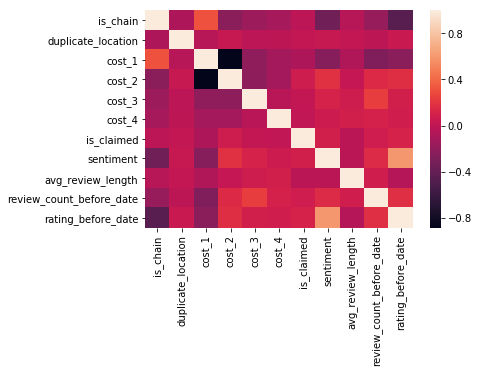

In [33]:
sns.heatmap(X.corr())
#X.drop(['age_at_date','num_rest_within_a_half_mile_at_date'],axis=1).corr()
#X.corr()

In [88]:
param_grid_logistic = {
    'logistic__C': np.logspace(-4, 4, 4),
    'logistic__solver' : [ 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logistic__max_iter' : [500, 1000, 2000]
}
param_grid_rf = {
    'rf__max_depth' : [4, 6, 8],
    'rf__n_estimators' : [500, 1000, 2000]
}

pipe = Pipeline([ ( 'scaler', StandardScaler() ), ( 'logistic', LogisticRegression(penalty='l2', class_weight='balanced') ) ])
#pipe = Pipeline([ ( 'rf', RandomForestClassifier(class_weight='balanced') ) ])
grid_search = GridSearchCV(pipe, param_grid_logistic, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)
y_pred_train = grid_search.best_estimator_.predict(X_train)
print "F1 Score:", f1_score(y_train, y_pred_train)
print "Precision Score:", precision_score(y_train, y_pred_train)
print "Recall Score:", recall_score(y_train, y_pred_train)
print "Accuracy Score:", accuracy_score(y_train, y_pred_train)
confusion_matrix(y_true=y_train, y_pred=y_pred_train)

Best parameter (CV score=0.936):
{'logistic__C': 10000.0, 'logistic__max_iter': 1000, 'logistic__solver': 'saga'}
Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=10000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False))])
F1 Score: 0.29095674967234597
Precision Score: 0.17076923076923076
Recall Score: 0.9823008849557522
Accuracy Score: 0.8198468198468198


array([[2351,  539],
       [   2,  111]])

F1 Score: 0.304093567251462
Precision Score: 0.1793103448275862
Recall Score: 1.0
Accuracy Score: 0.8415446071904128
Confusion matrix: [[606 119]
 [  0  26]]


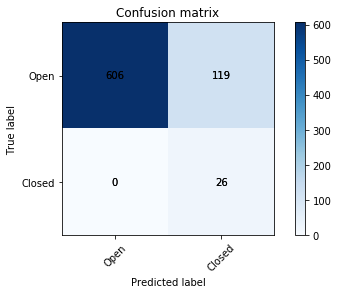

In [99]:
y_pred_test = grid_search.best_estimator_.predict(X_test)
print "F1 Score:", f1_score(y_test, y_pred_test)
print "Precision Score:", precision_score(y_test, y_pred_test)
print "Recall Score:", recall_score(y_test, y_pred_test)
print "Accuracy Score:", accuracy_score(y_test, y_pred_test)
print "Confusion matrix:", confusion_matrix(y_true=y_test, y_pred=y_pred_test)
plot_confusion_matrix(confusion_matrix(y_true=y_test, y_pred=y_pred_test))

In [35]:
model = Pipeline([ ( 'scaler', StandardScaler() ), ( 'lr', LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, class_weight='balanced') ) ])
#model = Pipeline([ ( 'scaler', StandardScaler() ), ( 'lr', RandomForestClassifier(max_depth=5, n_estimators=1000, class_weight='balanced') ) ])
model.fit(X_train_no_val, y_train_no_val)
y_pred_val = model.predict(X_train_val)
print "F1 score:", f1_score(y_train_val, y_pred_val)
print "Accuracy score:", accuracy_score(y_train_val, y_pred_val)
confusion_matrix(y_true=y_train_val, y_pred=y_pred_val)

F1 score: 0.2091503267973856
Accuracy score: 0.7986688851913477


array([[464, 121],
       [  0,  16]])

In [62]:
clf = RandomForestClassifier(max_depth=3, class_weight='balanced').fit(X_train_no_val, y_train_no_val)
y_pred_val = clf.predict(X_train_val)
print "F1 score:", f1_score(y_train_val, y_pred_val)
#print "Precision Score:", precision_score(y_train_val, y_pred_val)
#print "Recall Score:", recall_score(y_train_val, y_pred_val)
print "Accuracy score:", accuracy_score(y_train_val, y_pred_val)
confusion_matrix(y_true=y_train_val, y_pred=y_pred_val)

F1 score: 0.23357664233576642
Accuracy score: 0.8252911813643927


array([[480, 105],
       [  0,  16]])

In [37]:
### Define simplest model
clf = LogisticRegression(solver='lbfgs',max_iter=1000,random_state=42,class_weight='balanced').fit(X_train_no_val, y_train_no_val)
# do gridsearchCV, or stratified cross validation, get the best classifier and then do prediction
#cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
y_pred_val = clf.predict(X_train_val)
print "F1 score:", f1_score(y_train_val, y_pred_val)
print "Accuracy score:", accuracy_score(y_train_val, y_pred_val)
confusion_matrix(y_true=y_train_val, y_pred=y_pred_val)#(clf.predict_proba(X_train_val) >= 0.5).astype(int).sum(axis=1)) #y_pred_val

F1 score: 0.2091503267973856
Accuracy score: 0.7986688851913477


array([[464, 121],
       [  0,  16]])

In [ ]:
#(clf.predict_proba(X_train) >= 0.85).astype(int).sum(axis=1) #2059 for threshold of 0.75
#clf.predict_proba(X_train)
#clf.predict_proba( np.array([[0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 2.00000000e+00, 3.00000000e+01, 2.43333333e+00, \
#                              1.12000000e+02, 7.00000000e+00, 3.20000000e+01, 1.21000000e+02, 2.95000000e+02, 1.97300000e+03, 3.45900000e+03]]))

In [38]:
#clf.predict
clf.predict(X[X.index == '4qG3Gh8QyugC1XvoTlmgcQ'].values), clf.predict_proba(X[X.index == '4qG3Gh8QyugC1XvoTlmgcQ']), clf.predict_log_proba(X[X.index == '4qG3Gh8QyugC1XvoTlmgcQ'])

(array([0]),
 array([[0.99327479, 0.00672521]]),
 array([[-0.00674792, -5.00189233]]))

In [39]:
clf.coef_, clf.intercept_

(array([[-5.91339053e-01,  2.92917589e-01, -6.00841540e-01,
         -1.53732285e-01,  9.83008257e-02,  5.80703588e-01,
         -6.77307872e+00, -1.56116635e-01,  4.47145101e-04,
          2.51958731e-04,  5.53506309e-01]]), array([-0.08583133]))

In [ ]:
#name_to_id_dict = dict( (value, key) for key, value in yelp_businesses_df.name.iteritems())
#with open('app/static/name_to_id_dict.json', 'w') as fp:
#    json.dump(name_to_id_dict, fp)

In [ ]:
#with open('app/static/name_to_id_dict.json', 'r') as fp:
#    name_to_id_dict_2 = json.load(fp)
#name_to_id_dict == name_to_id_dict_2

In [ ]:
#id_to_features_dict = X.to_dict('index')
#with open('app/static/id_to_features_dict.json', 'w') as fp:
#    json.dump(id_to_features_dict, fp)

In [ ]:
#with open('app/static/id_to_features_dict.json', 'r') as fp:
#    id_to_features_dict_2 = json.load(fp)
#id_to_features_dict == id_to_features_dict_2

In [ ]:
X_train_val#, y_pred_val

In [ ]:
#confusion_matrix(y_true=y_train, y_pred=(clf.predict_proba(X_train) >= 0.75).astype(int).sum(axis=1))

In [ ]:
#clf.predict(X_train) # 2997 for threshold of 0.5

In [ ]:
#(clf.predict_proba(X_train) >= 0.75).astype(int).sum(axis=1) #2059 for threshold of 0.75

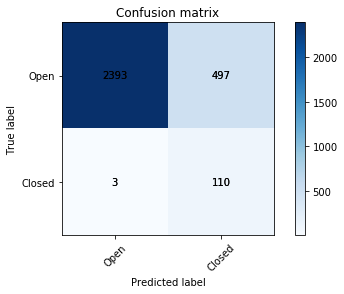

In [98]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = [0, 1]
    plt.xticks(tick_marks, ['Open','Closed'], rotation=45)
    plt.yticks(tick_marks, ['Open','Closed'])
    for (j,i),label in np.ndenumerate(cm):
        plt.text(i,j,label,ha='center',va='center')
        plt.text(i,j,label,ha='center',va='center')
    #plt.tick_params( axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion_matrix(y_true=y_train,y_pred=clf.predict(X_train)))

In [ ]:
### Make preds
y_pred = clf.predict(X_test)

In [ ]:
print "F1:", f1_score(y_test, y_pred)
print "Accuracy:", accuracy_score(y_test, y_pred)
print "Precision:", precision_score(y_test, y_pred)
print "Recall:", recall_score(y_test, y_pred)
print "Confusion matrix:"
print confusion_matrix(y_true=y_test, y_pred=y_pred)

In [ ]:
def dist_of_open_businesses_in_city(businesses_df, categories):
    open_businesses = []
    closed_businesses = []
    valid_categories = []
    
    for category in categories:
        category_df = businesses_df[businesses_df['categories'].str.contains(category, na=False)]
        num_open = category_df[category_df.is_open == 1].shape[0]
        num_closed = category_df[category_df.is_open == 0].shape[0]
        if num_open + num_closed > 100 and num_closed > 50:
            open_businesses.append(category_df[category_df.is_open == 1].shape[0])
            closed_businesses.append(category_df[category_df.is_open == 0].shape[0]) 
            valid_categories.append(category)
        
    city_business_distribution = pd.DataFrame(data={'Open' : open_businesses, 'Closed' : closed_businesses}, index=valid_categories)
    
    return city_business_distribution

city_business_distribution = dist_of_open_businesses_in_city(yelp_businesses_df, categories)
city_business_distribution

In [ ]:
#############
# FOCUS ON SCOPE AND TARGET AUDIENCE -- WHO WOULD USE THE PRODUCT AND WHY -- Just pick Las Vegas
# WHAT ARE YOU ACTUALLY PREDICTING...

# Signals: 
#      Age of business? Proxy can be time of first review -- Done
#      Density of other businesses in area? -- Done
#      Rating count? -- Done
#      Star rating? -- Done
#      Location? -- Done
#      Semantic analysis of text? -- Done
#      Hours of business? -- Ignore
#      Accept credit card? -- Ignore
#      Offers parking? -- Done
#      Is the business a chain? Are there others in the area? -- Done
#      Price relative to competitors? Review count relative to competitors? Star rating relative to competitors?
#      Look at geography in a given city. Are there locations in the city where businesses don't succeed -- Ignore for now
#      Useful, cool, funny reviews? -- Ignore/Done
#      Are some users more impactful?
#      Get city population/neighborhood data -- Ignore
#      Average length of review text -- Done
#      Investigate other cities
#      Change the date and forecast period
#      Number of restaurants with same category in city

#      Do AWS deployment
#      Flask/web app, think about how the input ---> model ---> output will work
#      Website output needs to show information about the restaurant
#      Change focus to food tourism where people are specifically picking restaurants, the project is not just about Las Vegas (Las Vegas is just a city in the food tourism space)
#      Numbers/stats can all be about food tourism now
#      Look at cost rating and see about fine dining (or not one $ restaurants) since those are ones that people actually care about

In [ ]:
# find out distribution of types of businesses in dataset
# find out closed business distribution by city, state
# perhaps look into time
# semantic analysis of text
# do the business hours matter in when stores open or close? are they related to type of business?
# does length of business name matter?
# does star number count?
# does business accept credit card matter?
# does parking matter?
# HuggingFace library BERT based on pytorch
# do certain user reviews matter?
# who is the user?
# how is it going to be used?